In [7]:
%pip install pandas
%pip install scikit-learn
%pip install Pillow
%pip install keras
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Load CSV files

### Connect csv data with images

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the base directory
base_dir = './aptos2019-blindness-detection'

# Load CSV files
train_df = pd.read_csv(f'{base_dir}/train.csv')
test_df = pd.read_csv(f'{base_dir}/test.csv')

# Add paths to the DataFrame
train_df['file_path'] = base_dir + '/train_images/' + train_df['id_code'] + '.png'
test_df['file_path'] = base_dir + '/test_images/' + test_df['id_code'] + '.png'


# Split the training data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['diagnosis'], random_state=42)

train_df['diagnosis'] = train_df['diagnosis'].astype(str)


print(train_df)
print(val_df)

           id_code diagnosis  \
1757  7c2e852171c0         0   
3080  d67374d3fa2a         2   
1136  4fef9ed8a4c5         3   
2146  976082127e2a         0   
3350  e868c3da340b         2   
...            ...       ...   
1248  5728b8aa98ef         0   
1687  772af553b8b7         3   
267   1438288bb2e1         2   
1501  6987804eb464         2   
3607  fc1b1841eadf         2   

                                              file_path  
1757  ./aptos2019-blindness-detection/train_images/7...  
3080  ./aptos2019-blindness-detection/train_images/d...  
1136  ./aptos2019-blindness-detection/train_images/4...  
2146  ./aptos2019-blindness-detection/train_images/9...  
3350  ./aptos2019-blindness-detection/train_images/e...  
...                                                 ...  
1248  ./aptos2019-blindness-detection/train_images/5...  
1687  ./aptos2019-blindness-detection/train_images/7...  
267   ./aptos2019-blindness-detection/train_images/1...  
1501  ./aptos2019-blindness-detecti

In [9]:
print(train_df["file_path"][0])

./aptos2019-blindness-detection/train_images/000c1434d8d7.png


Found 3295 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


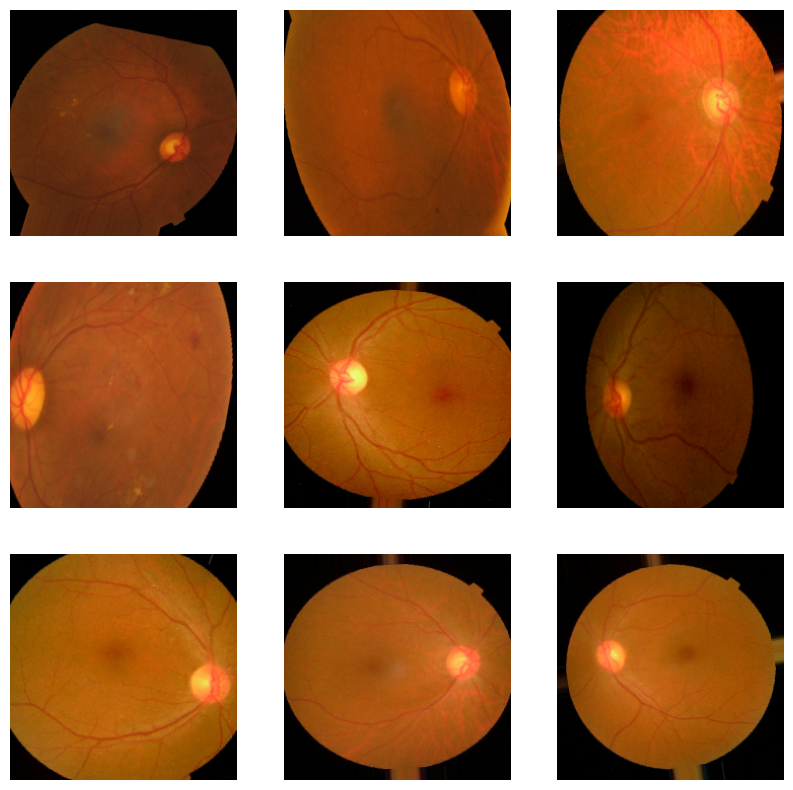

In [10]:
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define constants
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
EPOCHS = 30

# ImageDataGenerator for training with augmentation and validation without augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_df['diagnosis'] = val_df['diagnosis'].astype(str)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col=None,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)


images, labels = next(train_generator)
# Plot the first 9 images in the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


In [11]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


## Define the MobileNet Model

In [12]:
from keras._tf_keras.keras.applications import MobileNet
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load the MobileNet model with pre-trained weights, excluding the top layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Combine base model and custom layers into a new model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,968,133 (18.95 MB)

 Trainable params: 1,739,269 (6.63 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

## Train the Model

In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

# Save the trained model
model.save('mobilenet_diabetic_retinopathy.h5')


Epoch 1/30


/home/rakib/Desktop/Thesis/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-30 14:29:24.355495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-06-30 14:29:43.991040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-30 14:29:48.739618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-06-30 14:29:48.739843: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2024-06-30 14:29:48.93

102/102 ━━━━━━━━━━━━━━━━━━━━ 665s 6s/step - accuracy: 0.5008 - loss: 1.4282 - val_accuracy: 0.6591 - val_loss: 0.9156
Epoch 2/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.7812 - loss: 0.7626

2024-06-30 14:40:09.426155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7812 - loss: 0.7626 - val_accuracy: 0.6667 - val_loss: 0.7144
Epoch 3/30


2024-06-30 14:40:10.400979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 14:40:24.907457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-06-30 14:40:41.477780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-30 14:40:47.010856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 636s 6s/step - accuracy: 0.6973 - loss: 0.8776 - val_accuracy: 0.7301 - val_loss: 0.7891
Epoch 4/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.7500 - loss: 0.6892

2024-06-30 14:50:48.893690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7500 - loss: 0.6892 - val_accuracy: 0.8667 - val_loss: 0.6863
Epoch 5/30


2024-06-30 14:50:49.841976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 14:51:03.040969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-06-30 14:51:24.311952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 634s 6s/step - accuracy: 0.7169 - loss: 0.7924 - val_accuracy: 0.7358 - val_loss: 0.7746
Epoch 6/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.6250 - loss: 0.8935

2024-06-30 15:01:26.436459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6250 - loss: 0.8935 - val_accuracy: 0.7333 - val_loss: 0.9130
Epoch 7/30


2024-06-30 15:01:27.388735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 15:01:37.759217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-06-30 15:01:48.025585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-06-30 15:02:06.280461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 635s 6s/step - accuracy: 0.7020 - loss: 0.8025 - val_accuracy: 0.7472 - val_loss: 0.7455
Epoch 8/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.7812 - loss: 0.6775

2024-06-30 15:12:04.558752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7812 - loss: 0.6775 - val_accuracy: 0.6667 - val_loss: 1.0710
Epoch 9/30


2024-06-30 15:12:05.459526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 15:12:19.476404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-06-30 15:12:39.862820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 634s 6s/step - accuracy: 0.7051 - loss: 0.8100 - val_accuracy: 0.7472 - val_loss: 0.7283
Epoch 10/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - accuracy: 0.7500 - loss: 0.8020

2024-06-30 15:22:41.295895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7500 - loss: 0.8020 - val_accuracy: 0.5333 - val_loss: 0.9401
Epoch 11/30


2024-06-30 15:22:42.213728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 15:22:54.948593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-06-30 15:23:15.378700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 654s 6s/step - accuracy: 0.7325 - loss: 0.7246 - val_accuracy: 0.7216 - val_loss: 0.7354
Epoch 12/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.6875 - loss: 0.8613

2024-06-30 15:33:38.099339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6875 - loss: 0.8613 - val_accuracy: 0.8667 - val_loss: 0.4538
Epoch 13/30


2024-06-30 15:33:39.046808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 15:33:53.079402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-06-30 15:34:13.531529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-30 15:34:17.882437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 818s 8s/step - accuracy: 0.7330 - loss: 0.7185 - val_accuracy: 0.7415 - val_loss: 0.7454
Epoch 14/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 4:11 2s/step - accuracy: 0.8125 - loss: 0.6846

2024-06-30 15:47:19.801043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8125 - loss: 0.6846 - val_accuracy: 0.8667 - val_loss: 0.7170
Epoch 15/30


2024-06-30 15:47:20.877941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 15:48:34.677718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 670s 6s/step - accuracy: 0.7310 - loss: 0.7271 - val_accuracy: 0.7074 - val_loss: 0.7684
Epoch 16/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3:45 2s/step - accuracy: 0.7500 - loss: 0.6472

2024-06-30 15:58:33.113504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7500 - loss: 0.6472 - val_accuracy: 0.4667 - val_loss: 1.2804
Epoch 17/30


2024-06-30 15:58:34.065912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 15:59:10.748062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 643s 6s/step - accuracy: 0.7289 - loss: 0.7072 - val_accuracy: 0.7131 - val_loss: 0.8184
Epoch 18/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3:57 2s/step - accuracy: 0.7188 - loss: 0.6561

2024-06-30 16:09:19.286966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7188 - loss: 0.6561 - val_accuracy: 0.8000 - val_loss: 0.4551
Epoch 19/30


2024-06-30 16:09:20.216720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 16:09:55.598904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 649s 6s/step - accuracy: 0.7287 - loss: 0.7253 - val_accuracy: 0.7386 - val_loss: 0.7027
Epoch 20/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3:51 2s/step - accuracy: 0.7188 - loss: 0.7462

2024-06-30 16:20:11.643580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7188 - loss: 0.7462 - val_accuracy: 0.8000 - val_loss: 0.4108
Epoch 21/30


2024-06-30 16:20:12.448825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 16:20:48.883673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 8955s 88s/step - accuracy: 0.7311 - loss: 0.6887 - val_accuracy: 0.7528 - val_loss: 0.7318
Epoch 22/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 4:14 3s/step - accuracy: 0.7812 - loss: 0.6951

2024-06-30 18:49:30.194063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 18:49:31.216526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7812 - loss: 0.6951 - val_accuracy: 0.6667 - val_loss: 0.6054
Epoch 23/30


2024-06-30 18:50:08.341376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 626s 6s/step - accuracy: 0.7352 - loss: 0.6906 - val_accuracy: 0.7017 - val_loss: 0.7362
Epoch 24/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - accuracy: 0.7188 - loss: 0.7609

2024-06-30 18:59:59.202969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7188 - loss: 0.7609 - val_accuracy: 0.7333 - val_loss: 0.6404
Epoch 25/30


2024-06-30 19:00:00.117585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 19:00:36.792684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - accuracy: 0.7405 - loss: 0.7007 - val_accuracy: 0.7443 - val_loss: 0.7085
Epoch 26/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.5625 - loss: 0.8323

2024-06-30 19:10:24.851726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5625 - loss: 0.8323 - val_accuracy: 0.8667 - val_loss: 0.6307
Epoch 27/30


2024-06-30 19:10:25.630875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 19:11:56.278487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 677s 6s/step - accuracy: 0.7509 - loss: 0.6720 - val_accuracy: 0.7386 - val_loss: 0.6854
Epoch 28/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - accuracy: 0.7188 - loss: 0.6638

2024-06-30 19:21:45.145993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7188 - loss: 0.6638 - val_accuracy: 0.6667 - val_loss: 0.8192
Epoch 29/30


2024-06-30 19:21:45.899445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 19:22:19.290616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 628s 6s/step - accuracy: 0.7461 - loss: 0.6833 - val_accuracy: 0.7415 - val_loss: 0.7626
Epoch 30/30
  1/102 ━━━━━━━━━━━━━━━━━━━━ 4:21 3s/step - accuracy: 0.7812 - loss: 0.5743

2024-06-30 19:32:16.924730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7812 - loss: 0.5743 - val_accuracy: 0.7333 - val_loss: 0.6716


2024-06-30 19:32:17.862960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Evaluate the Model

In [14]:
import os

# Ensure all images listed in test_df exist
missing_files = [f for f in test_df['file_path'] if not os.path.exists(f)]
if missing_files:
    print(f"Missing files: {len(missing_files)}")
    print(missing_files[:10])  # Print first 10 missing files for debugging

# Check the data generator output
batch = next(test_generator)
print(f"Batch shape: {batch.shape}")

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(val_generator, steps=val_generator.samples // BATCH_SIZE)
print(f'Validation Accuracy: {val_acc:.2f}')

# Make predictions on the test data
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)

# Process the predictions to get the class with the highest probability
predicted_classes = predictions.argmax(axis=-1)

test_df=test_df[:1920]

# Verify the lengths
print(f"Length of test_df: {len(test_df)}")
print(f"Length of predicted_classes: {len(predicted_classes)}")

# Ensure the lengths match
if len(test_df) != len(predicted_classes):
    raise ValueError("The length of predicted_classes does not match the length of test_df['id_code']")

# Create a DataFrame for the submission
submission_df = pd.DataFrame({'id_code': test_df['id_code'], 'diagnosis': predicted_classes})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully.")


Batch shape: (32, 224, 224, 3)
11/11 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.7613 - loss: 0.6646
Validation Accuracy: 0.74
60/60 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step
Length of test_df: 1920
Length of predicted_classes: 1920
Submission file created successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


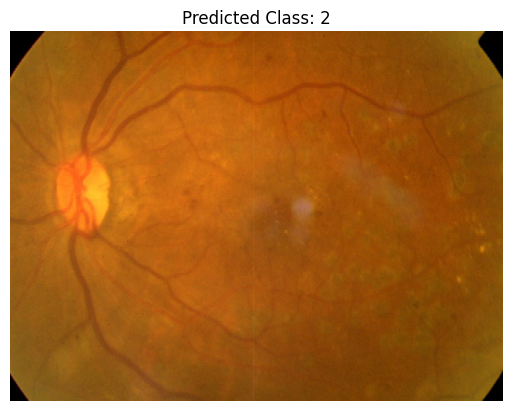

Predicted class for the input image is: 2


In [18]:
from keras._tf_keras.keras.preprocessing.image import load_img, img_to_array
from keras._tf_keras.keras.models import load_model
import matplotlib.pyplot as plt

# Define paths and parameters
TEST_IMAGES_DIR = './aptos2019-blindness-detection/test_images/'
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32 

# Load the trained model
model = load_model('./mobilenet_diabetic_retinopathy.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a function to preprocess and predict a single image
def preprocess_and_predict(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image

    # Predict using the trained model
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=-1)[0]

    return predicted_class

# Define a function to visualize the input image and prediction
def visualize_prediction(image_path, predicted_class):
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
input_image_path = './0ad36156ad5d.png' 
predicted_class = preprocess_and_predict(input_image_path)
visualize_prediction(input_image_path, predicted_class)

print(f"Predicted class for the input image is: {predicted_class}")


In [20]:
match predicted_class:
    case 0:
        print("No DR (absence of any DR-related symptoms in the retinal picture!)")

    case 1:
        print("Predicted class: Mild")

    case 2:
        print("Predicted class: Moderate")
    
    case 3:
        print("Predicted class: Proliferative")

    case 4:
        print("Predicted class: Severe")
    case _:
        print("Can't Predicted")

print(f'Accuracy: {int((val_acc)*100)}%')

Predicted class: Moderate
Accuracy: 73%
